In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
test_set = pd.read_csv("data/test_set.csv")
train_set = pd.read_csv("data/train_set.csv")

In [3]:
train_set

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,0,1,25,0,0,0,1,1,...,1,0,2,1,1,0,0,11,6,8
1,0,0,0,0,33,0,0,0,1,1,...,1,0,3,3,1,0,1,7,4,8
2,0,1,0,1,33,1,0,0,1,1,...,1,0,4,1,1,0,0,8,4,3
3,2,1,1,1,26,1,1,1,1,1,...,1,0,3,1,1,1,1,12,6,3
4,0,1,1,1,35,1,0,0,0,1,...,1,0,4,3,2,1,0,11,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174329,0,0,0,1,27,1,0,0,1,0,...,1,0,2,1,1,0,1,11,4,7
174330,2,1,1,1,36,0,0,1,0,1,...,1,0,5,1,6,1,0,10,4,3
174331,0,1,1,1,31,0,0,0,1,1,...,1,0,2,1,1,0,0,10,6,8
174332,0,1,0,1,38,0,0,0,1,1,...,1,0,3,1,3,0,0,1,4,5


In [4]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

train_binary_scaled = pd.DataFrame(min_max_scaler.fit_transform(train_set.values), columns=train_set.columns, index=train_set.index)
test_binary_scaled = pd.DataFrame(min_max_scaler.transform(test_set.values), columns=test_set.columns, index=test_set.index)

X_train = train_binary_scaled.drop("Diabetes_012", axis = 1)
y_train = train_binary_scaled["Diabetes_012"]

X_test = test_binary_scaled.drop("Diabetes_012", axis = 1)
y_test = test_binary_scaled["Diabetes_012"]

### Evaluate a few models based on roc_auc, without hyperparameter tuning

In [5]:
models = {"Logistic Regression": LogisticRegression(), 
          "KNN": KNeighborsClassifier(), 
          "Decision Tree Classifier": DecisionTreeClassifier(),
          "Random Forest Classifier": RandomForestClassifier()
         }
results = []

In [6]:
for model in models.values():
    kf = KFold(n_splits = 3, random_state = 420, shuffle = True)
    res_for_model = cross_val_score(model, X_train, y_train, cv = kf, scoring = "roc_auc")
    results.append(res_for_model)

i = 0
for name in models.keys():
    print("Roc_auc scores for ", name, ": ", results[i])
    print("Mean roc_auc_score for ", name, ": ", np.mean(results[i]))
    print("Median roc_auc_score for ", name, ": ", np.median(results[i]), "\n")
    i = i+1

plt.figure(figsize = (7,7))
plt.boxplot(results, labels = models.keys())
plt.show()

KeyboardInterrupt: 

### Estimated roc_auc scores for models:
Median roc_auc_score for  Logistic Regression :  0.8235191188536042 

Median roc_auc_score for  KNN :  0.7186383191172674 

Median roc_auc_score for  Decision Tree Classifier :  0.6025431389404231 

Median roc_auc_score for  Random Forest Classifier :  0.7966651322736205 


In [ ]:
#%pip install lazypredict
%pip install --upgrade scikit-learn


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 35.0 MB/s eta 0:00:0000:0100:01
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.4.1.post1
    Uninstalling scikit-learn-1.

In [4]:
import pandas as pd

X_train = pd.read_csv("data/X_train_filtered.csv")
X_test = pd.read_csv("data/X_test_filtered.csv")
y_train = pd.read_csv("data/y_train.csv")
y_test = pd.read_csv("data/y_test.csv")

#apply here a gridsearch with all classification algorithms
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
#everything! if xgboost is possible, also it
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt






    






/home/iwaniukooo/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  0.7308498773142985
AUC:  0.745827116636986
Confusion Matrix: 
 [[13943  5291]
 [  742  2439]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.95      0.72      0.82     19234
         1.0       0.32      0.77      0.45      3181

    accuracy                           0.73     22415
   macro avg       0.63      0.75      0.63     22415
weighted avg       0.86      0.73      0.77     22415



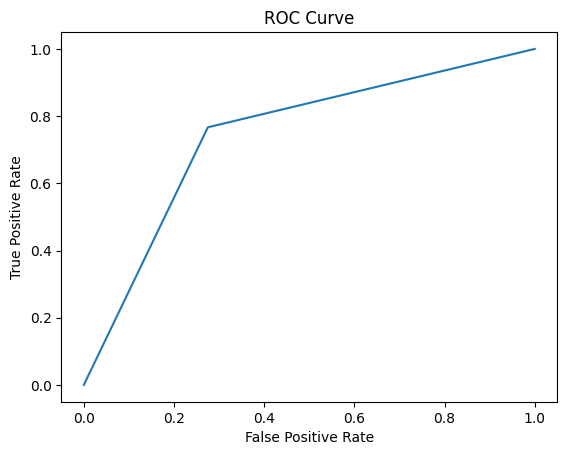

In [5]:
#run logistic regression and show score, auc
log_reg = LogisticRegression(penalty='l2',dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight='balanced', random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
#print accuracy, auc, confusion matrix, classification report, roc curve
print("Accuracy: ", log_reg.score(X_test, y_test))
print("AUC: ", roc_auc_score(y_test, y_pred))
from sklearn.metrics import confusion_matrix
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
from sklearn.metrics import classification_report
print("Classification Report: \n", classification_report(y_test, y_pred))
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()




In [8]:
#run knn and show score, auc
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
roc_auc_score(y_test, y_pred)

#run decision tree and show score, auc
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Accuracy: ", knn.score(X_test, y_test))
print("AUC: ", roc_auc_score(y_test, y_pred))




/home/iwaniukooo/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy:  0.8423377202766005
AUC:  0.5999940768203064


In [9]:
#run random forest and show score, auc
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Accuracy: ", rf.score(X_test, y_test))
print("AUC: ", roc_auc_score(y_test, y_pred))



/home/iwaniukooo/.local/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy:  0.8453714030782958
AUC:  0.5888829746077667


In [11]:
# #run svc and show score, auc
# svc = SVC()
# svc.fit(X_train, y_train)
# y_pred = svc.predict(X_test)
# roc_auc_score(y_test, y_pred)



/home/iwaniukooo/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


: 

: 

In [ ]:
# #run xgboost and show score, auc
# xgb = XGBClassifier()
# xgb.fit(X_train, y_train)
# y_pred = xgb.predict(X_test)
# roc_auc_score(y_test, y_pred)

In [10]:
#prepare hiper parametrizatiuon for logistic regression
# param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
#               'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#               'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
# grid = GridSearchCV(log_reg, param_grid, cv=3, scoring='roc_auc')
# grid.fit(X_train, y_train)
# print("Best parameters for logistic regression: ", grid.best_params_)
# print("Best score for logistic regression: ", grid.best_score_)
# y_pred = grid.predict(X_test)
# print("AUC: ", roc_auc_score(y_test, y_pred))


/home/iwaniukooo/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/iwaniukooo/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/iwaniukooo/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/iwaniukooo/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

Best parameters for logistic regression:  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best score for logistic regression:  0.8233916678888663
AUC:  0.7458803173817505


In [14]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, recall_score

# Define the parameter grid with lof ot parameters
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'max_iter': [100, 1000, 10000, 100000]}


# Define the model
log_reg = LogisticRegression()

# Define the scorer
scorer = make_scorer(recall_score)

# Define the grid search
grid_search = RandomizedSearchCV(log_reg, param_grid, scoring=scorer, cv=5, n_iter=50, random_state=0)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

/home/iwaniukooo/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=50. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/iwaniukooo/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/iwaniukooo/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/iwaniukooo/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

Best parameters:  {'solver': 'liblinear', 'penalty': 'l2', 'C': 100}
Best score:  0.16595243186239333


/home/iwaniukooo/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  0.860272139192505
AUC:  0.5693601727031834


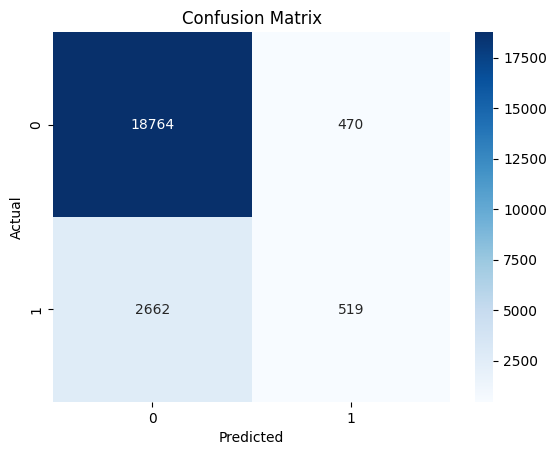

In [15]:
#prepare confussion matrix, roc curve and classification report for  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
log_reg = LogisticRegression(C=100, penalty='l2', solver='liblinear')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print("Accuracy: ", log_reg.score(X_test, y_test))
print("AUC: ", roc_auc_score(y_test, y_pred))
from sklearn.metrics import confusion_matrix
#plot the confusion matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()




In [16]:
from sklearn.metrics import classification_report
print("Classification Report: \n", classification_report(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.88      0.98      0.92     19234
         1.0       0.52      0.16      0.25      3181

    accuracy                           0.86     22415
   macro avg       0.70      0.57      0.59     22415
weighted avg       0.83      0.86      0.83     22415



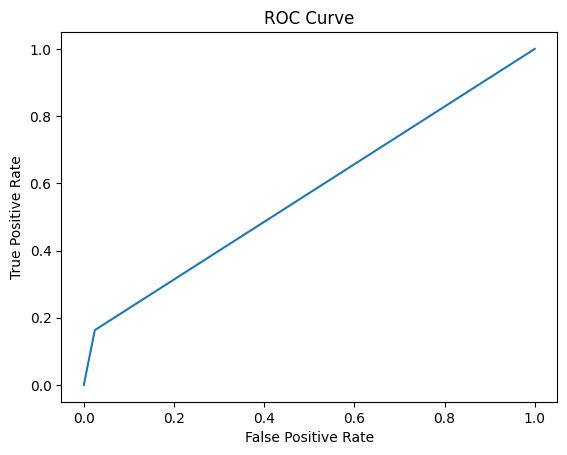

In [17]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()